# Study of ring systems in the dataset

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
IPythonConsole.drawOptions.addAtomIndices = False
import pandas as pd
import numpy as np

In [2]:
# Importing the dataset
drugs_db_route_merged = pd.read_csv('../data/approved_drugs_final_2022.csv')

# Get a list of all the SMILES
drugs_smiles = list(drugs_db_route_merged.SMILES)

In [3]:
# Definying a function to get all the rings
def get_ring_atoms(mol, includeSpiro=False):
    ri = mol.GetRingInfo()
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return [list(ring_idx) for ring_idx in systems] 

# Definying a function to get the ring SMILES of a structure
def get_substructure_smiles(smile):
    mol = Chem.MolFromSmiles(smile)
    substructure_smiles = []
    for ring in get_ring_atoms(mol):
        substructure_smiles.append(Chem.MolFragmentToSmiles(mol, ring, canonical=True))
    return substructure_smiles


In [4]:
test = drugs_smiles[0:5]

rings_smiles = []
for drug in test:
    rings_smiles.append(get_substructure_smiles(drug))

# We need to flatten the list of rings' smiles because it is a list of list
# I found this solution online using numpy
rings_smiles = list(np.concatenate(rings_smiles))

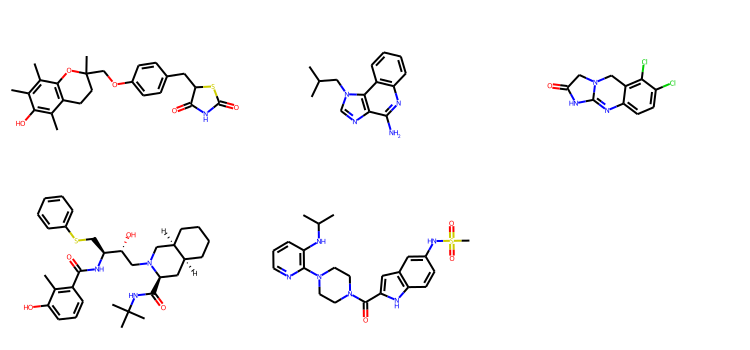

In [5]:
test_mol = [Chem.MolFromSmiles(drug) for drug in test]
Draw.MolsToGridImage(test_mol, subImgSize=(250,175))

In [6]:
# Counting the SMILES appearances:
counter = {}
for ring_smile in rings_smiles:
    counter[ring_smile] = counter.get(ring_smile, 0) + 1

# Transforming it into a pandas object:
rings_df = pd.DataFrame.from_dict(counter, orient='index', columns=['n'])
rings_df = rings_df.reset_index()
rings_df.rename(columns={'index':'SMILES'}, inplace=True)

# Descending order
rings_df.sort_values(by='n', ascending=False)

,SMILES,n
1,c1ccccc1,3
0,c1ccc2c(c1)CCCO2,1
2,C1CSCN1,1
3,c1ccc2c(c1)ncc1ncnc12,1
4,C1CN2Cc3ccccc3N=C2N1,1
5,C1CC[C@@H]2CNCC[C@@H]2C1,1
6,c1ccncc1,1
7,C1CNCCN1,1
8,c1ccc2[nH]ccc2c1,1


RDKit ERROR: [19:55:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[19:55:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12


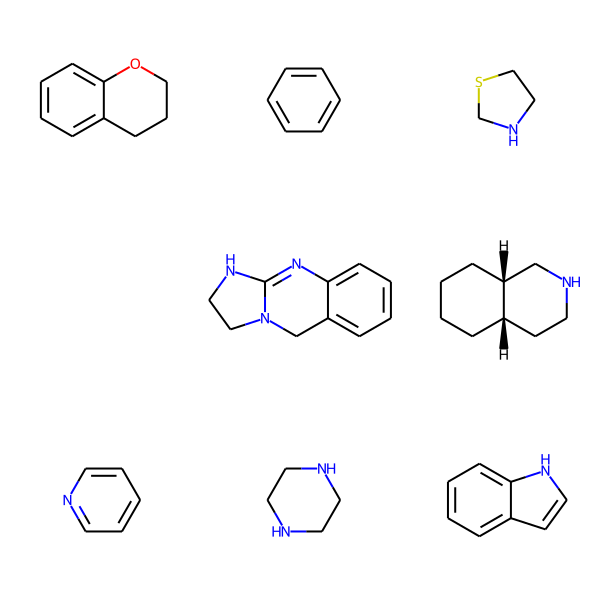

In [7]:
mol_rings = [Chem.MolFromSmiles(SMILES) for SMILES in list(rings_df.SMILES)]
Draw.MolsToGridImage(mol_rings)